# 1. Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
import json
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
cd '../'

/Users/andyvillanuevamartinez/Library/CloudStorage/GoogleDrive-villanuevaoct@gmail.com/My Drive/MAC/cursos/machine_learning/15_udacity_nanodegree_ds/11. capstone/starbucks_offer_recommendation


# 2. Data Preprocessing

In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

print(profile.shape)
print(profile.id.nunique())
display(profile.head(2))

print(portfolio.shape)
print(portfolio.id.nunique())
display(portfolio.head(2))

print(transcript.shape)
print(transcript.person.nunique())
display(transcript.head(2))

(17000, 5)
17000


gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0

(10, 6)
10


reward                      channels  difficulty  duration offer_type  \
0      10       [email, mobile, social]          10         7       bogo   
1      10  [web, email, mobile, social]          10         5       bogo   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0

(306534, 4)
17000


person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0

In [5]:
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [6]:
profile.rename(columns = {'id':'id_customer'}, inplace = True)
portfolio.rename(columns = {'id':'id_offer', 'reward':'expected_reward'}, inplace = True)

In [7]:
# create dataframe from records in value column
aux = pd.DataFrame.from_records(transcript['value'].tolist())
aux['offer id'] = np.where(aux['offer id'].isna(), aux['offer_id'], aux['offer id'])
del aux['offer_id']
aux['offer id'].fillna('transaction', inplace = True)
aux = transcript.join(aux)
aux.rename(columns = {'person':'id_customer', 'offer id':'id_offer', 'reward':'reward_txs'}, inplace = True)
del aux['value']

aux = aux[['id_offer','id_customer','event','time','amount','reward_txs']]

# merging the dataframes
df = aux.merge(portfolio, on = 'id_offer', how = 'left')
df = df.merge(profile, on = 'id_customer', how = 'left')

# create flag column for each channel
df['flag_email'] = df.channels.astype(str).str.contains('email')*1
df['flag_mobile'] = df.channels.astype(str).str.contains('mobile')*1
df['flag_web'] = df.channels.astype(str).str.contains('web')*1
df['flag_social'] = df.channels.astype(str).str.contains('social')*1
df['age'] = np.where(df['age']==118, np.nan, df['age'])

del df['channels']
del df['flag_email']

In [216]:
df.groupby('id_offer').agg({'id_customer':'count'}).sort_values(by = 'id_customer', ascending = False)

id_customer
id_offer                                     
transaction                            138953
fafdcd668e3743c1bb461111dcafc2a4        20241
2298d6c36e964ae4a3e7e9706d1fb8c2        20139
f19421c1d4aa40978ebb69ca19b0e20d        19131
4d5c57ea9a6940dd891ad53e9dbe8da0        18222
ae264e3637204a6fb9bb56bc8210ddfd        18062
9b98b8c7a33c4b65b9aebfe6a799e6d9        16202
2906b810c7d4411798c6938adc9daaa5        15767
5a8bc65990b245e5a138643cd4eb9837        14305
0b1e1539f2cc45b7b9fa7c272da2e1d7        13751
3f207df678b143eea3cee63160fa8bed        11761

# 3. Implementation

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, classification_report

import joblib

In [202]:
catcols = ['gender']
numcols = ['age','income']

cat_pipeline = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('encoding', OrdinalEncoder())
])

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

column_transformer = ColumnTransformer(transformers = [
    ('cat_pipeline', cat_pipeline, catcols),
    ('num_pipeline', num_pipeline, numcols)
    ],
    remainder = 'drop', # ignorar otras columnas
    n_jobs = -1)

## 3.1. Best channel to contact

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
# we focus only on the offers seen to estimate which channel is causing this effect
df1 = df[df['event']=='offer viewed']

In [9]:
X = df1[['gender', 'age', 'income']]
Y = df1[['flag_mobile','flag_web','flag_social']]
targets = Y.columns
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [11]:
model = Pipeline(steps = [
    ('preprocessing',column_transformer),
    ('model', MultiOutputClassifier(RandomForestClassifier(n_jobs = -1)))
])

In [14]:
model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  ['gender']),
                                                 ('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'income'])])),
                ('model',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_jobs=-1)))])

### 3.1.1. Evaluation

In [16]:
Y_pred = model.predict(X_test)
for j, col in enumerate(targets):
    print('='*25,col,'='*25)
    print(classification_report(Y_test[col], Y_pred[:,j]))
    print(confusion_matrix(Y_test[col], Y_pred[:,j]))

========================= flag_mobile =========================
              precision    recall  f1-score   support

           0       0.02      0.00      0.00       519
           1       0.95      1.00      0.98     11026

    accuracy                           0.95     11545
   macro avg       0.49      0.50      0.49     11545
weighted avg       0.91      0.95      0.93     11545

[[    1   518]
 [   43 10983]]
========================= flag_web =========================
              precision    recall  f1-score   support

           0       0.23      0.08      0.12      2616
           1       0.77      0.92      0.84      8929

    accuracy                           0.73     11545
   macro avg       0.50      0.50      0.48     11545
weighted avg       0.65      0.73      0.68     11545

[[ 208 2408]
 [ 711 8218]]
========================= flag_social =========================
              precision    recall  f1-score   support

           0       0.32      0.12      0.17 

In [19]:
joblib.dump(model, 'objects/best_channel.pkl', compress = True)

['objects/best_channel.pkl']

## 3.2. Spend model

In [184]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [204]:
# we focus only on transactions to estimate spending for each profile
df1 = df[df['event']=='transaction']
df1

id_offer                       id_customer        event  time  \
12654   transaction  02c083884c7d45b39cc68e1314fec56c  transaction     0   
12657   transaction  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  transaction     0   
12659   transaction  54890f68699049c2a04d415abc25e717  transaction     0   
12670   transaction  b2f1cd155b864803ad8334cdf13c4bd2  transaction     0   
12671   transaction  fe97aa22dd3e48c8b143116a8403dd52  transaction     0   
...             ...                               ...          ...   ...   
306529  transaction  b3a1272bc9904337b331bf348c3e8c17  transaction   714   
306530  transaction  68213b08d99a4ae1b0dcb72aebd9aa35  transaction   714   
306531  transaction  a00058cf10334a308c68e7631c529907  transaction   714   
306532  transaction  76ddbd6576844afe811f1a3c0fbb5bec  transaction   714   
306533  transaction  c02b10e8752c4d8e9b73f918558531f7  transaction   714   

        amount  reward_txs  expected_reward  difficulty  duration offer_type  \
12654     0.83         NaN              NaN         NaN       NaN        NaN   
12657    34.56         NaN              NaN         NaN       NaN        NaN   
12659    13.23         NaN              NaN         NaN       NaN        NaN   
12670    19.51         NaN              NaN         NaN       NaN        NaN   
12671    18.97         NaN              NaN         NaN       NaN        NaN   
...        ...         ...              ...         ...       ...        ...   
306529    1.59         NaN              NaN         NaN       NaN        NaN   
306530    9.53         NaN              NaN         NaN       NaN        NaN   
306531    3.61         NaN              NaN         NaN       NaN        NaN   
306532    3.53         NaN              NaN         NaN       NaN        NaN   
306533    4.05         NaN              NaN         NaN       NaN        NaN   

       gender   age  became_member_on   income  flag_mobile  flag_web  \
12654       F  20.0          20160711  30000.0            0         0   
12657       M  42.0          20160117  96000.0            0         0   
12659       M  36.0          20171228  56000.0            0         0   
12670       F  55.0          20171016  94000.0            0         0   
12671       F  39.0          20171217  67000.0            0         0   
...       ...   ...               ...      ...          ...       ...   
306529      M  66.0          20180101  47000.0            0         0   
306530      M  52.0          20180408  62000.0            0         0   
306531      F  63.0          20130922  52000.0            0         0   
306532      M  57.0          20160709  40000.0            0         0   
306533   None   NaN          20151211      NaN            0         0   

        flag_social  
12654             0  
12657             0  
12659             0  
12670             0  
12671             0  
...             ...  
306529            0  
306530            0  
306531            0  
306532            0  
306533            0  

[138953 rows x 17 columns]

In [186]:
df1['amount'].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

In [138]:
X = df1[['gender', 'age', 'income']]
y = df1['amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [139]:
catcols = ['gender']
numcols = ['age','income']

parameters = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [50, 100],
}

pipe = Pipeline(steps = [
    ('preprocessing',column_transformer),
    ('model', RandomForestRegressor(random_state=0))
])

In [140]:
model = GridSearchCV(pipe, parameters, cv = 5, n_jobs = -1)
model.fit(X_train, y_train)
best_model = model.best_estimator_

In [141]:
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  ['gender']),
                                                 ('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'income'])])),
                ('model',
                 RandomForestRegressor(max_depth=5, min_samples_split=100,
                                       random_state=0))])

### 3.2.1. Evaluation

Mean Squared Error (MSE): 879.8499260548921
Root Mean Squared Error (RMSE): 29.662264344700525


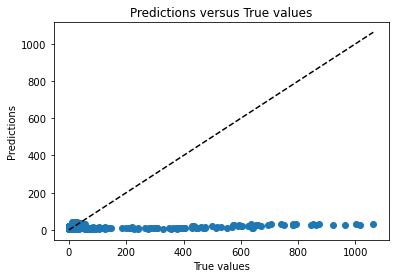

In [142]:
y_pred = best_model.predict(X_test)
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('Predictions versus True values')
plt.show()

### 3.2.2. Refinement
Due to the lousy performance of the model and the high RMSE values, what we can do is cut the variable into small intervals, to reduce the effect of each error and focus on predicting the correct interval, especially due to the presence of outliers in the target . 
To do this, we will obtain the value of the percentiles 5, 10, 15, .. 95 as cut points and each of the intervals defined by these points will be my new target.

In [187]:
df1['amount'].describe() # outliers detected in target, we can cut the values by percentiles and estimate that values with a regression

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

In [205]:
cuts = np.percentile(df1['amount'].values, q = np.arange(5, 100, 5))
print(cuts)
df1['amount'] = np.digitize(df1['amount'], bins = cuts, ) + 1

X = df1[['gender', 'age', 'income']]
y = df1['amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

[ 0.59   1.08   1.58   2.14   2.78   3.52   4.45   5.64   7.154  8.89
 10.71  12.51  14.31  16.15  18.07  20.15  22.52  25.49  29.91 ]


<ipython-input-205-73f235e0eb89>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['amount'] = np.digitize(df1['amount'], bins = cuts, ) + 1


In [206]:
catcols = ['gender']
numcols = ['age','income']

parameters = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [50, 100],
}

pipe = Pipeline(steps = [
    ('preprocessing',column_transformer),
    ('model', RandomForestRegressor(random_state=0))
])

In [207]:
model = GridSearchCV(pipe, parameters, cv = 5, n_jobs = -1)
model.fit(X_train, y_train)
best_model = model.best_estimator_

In [208]:
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  ['gender']),
                                                 ('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'income'])])),
                ('model',
                 RandomForestRegressor(max_depth=5, min_samples_split=50,
                                       n_estimators=200, random_state=0))])

### 3.2.3. Evaluation

Mean Squared Error (MSE): 15.699923275220716
Root Mean Squared Error (RMSE): 3.962312869426229


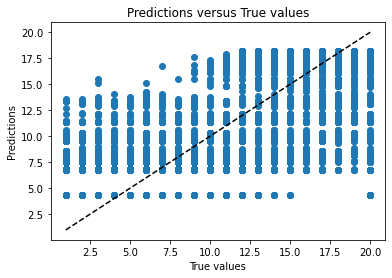

In [209]:
y_pred = best_model.predict(X_test)
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('Predictions versus True values')
plt.show()

In [210]:
joblib.dump(best_model, 'objects/spend.pkl', compress = True)
np.save('objects/cuts_spend.npy', cuts) # save
#new_num_arr = np.load('data.npy') # load

## 3.3. Time to complete offer

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [111]:
# we need to define the universe of customers who saw a certain offer, and after a certain time completed it. 
# This is to find out which customer profile takes more or less time to complete an offer. Let's take this client as an example.
pr = df[(df['id_customer']=='ffff82501cea40309d5fdd7edcca4a07')&(df['id_offer']=='2906b810c7d4411798c6938adc9daaa5')][['id_offer','id_customer','event','time']]
pr = pr[pr['event'].isin(['offer viewed','offer completed'])]
pr

id_offer                       id_customer  \
133074  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   
143788  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   
168022  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   
168024  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   
258362  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   
262475  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   

                  event  time  
133074     offer viewed   354  
143788  offer completed   384  
168022     offer viewed   414  
168024  offer completed   414  
258362  offer completed   576  
262475     offer viewed   582

In [112]:
# We noticed that the client took 30 hours to complete the offer the first time, then 0 hours, and finally completed the offer but then saw it, the latter should not count.
pr['time_diff'] = pr.groupby(['id_customer','id_offer'])['time'].diff()
pr['flag'] = pr['event'].map({'offer viewed':1, 'offer completed':-1})
pr['flag_diff'] = pr['flag'].cumsum()
#pr = pr[(pr['event']=='offer completed')&(pr['flag_diff']==0)]
pr

id_offer                       id_customer  \
133074  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   
143788  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   
168022  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   
168024  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   
258362  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   
262475  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   

                  event  time  time_diff  flag  flag_diff  
133074     offer viewed   354        NaN     1          1  
143788  offer completed   384       30.0    -1          0  
168022     offer viewed   414       30.0     1          1  
168024  offer completed   414        0.0    -1          0  
258362  offer completed   576      162.0    -1         -1  
262475     offer viewed   582        6.0     1          0

In [143]:
df1 = df[df['event'].isin(['offer viewed','offer completed'])].sort_values(by = ['id_customer', 'time'], ascending = True)
df1['time_diff'] = df1.groupby(['id_customer','id_offer'])['time'].diff()
df1['flag'] = df1['event'].map({'offer viewed':1, 'offer completed':-1})
df1['flag_diff'] = df1.groupby(['id_customer','id_offer'])['flag'].cumsum()
df1 = df1[(df1['event']=='offer completed')&(df1['flag_diff']==0)]
df1

id_offer                       id_customer  \
95422   2298d6c36e964ae4a3e7e9706d1fb8c2  0011e0d4e6b944f998e987f904e8c1e5   
258980  0b1e1539f2cc45b7b9fa7c272da2e1d7  0011e0d4e6b944f998e987f904e8c1e5   
258981  9b98b8c7a33c4b65b9aebfe6a799e6d9  0011e0d4e6b944f998e987f904e8c1e5   
31327   fafdcd668e3743c1bb461111dcafc2a4  0020c2b971eb4e9188eac86d93036a77   
218937  4d5c57ea9a6940dd891ad53e9dbe8da0  0020c2b971eb4e9188eac86d93036a77   
...                                  ...                               ...   
221937  f19421c1d4aa40978ebb69ca19b0e20d  fffad4f4828548d1b5583907f2e9906b   
32763   fafdcd668e3743c1bb461111dcafc2a4  ffff82501cea40309d5fdd7edcca4a07   
79668   0b1e1539f2cc45b7b9fa7c272da2e1d7  ffff82501cea40309d5fdd7edcca4a07   
143788  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   
168024  2906b810c7d4411798c6938adc9daaa5  ffff82501cea40309d5fdd7edcca4a07   

                  event  time  amount  reward_txs  expected_reward  \
95422   offer completed   252     NaN         3.0              3.0   
258980  offer completed   576     NaN         5.0              5.0   
258981  offer completed   576     NaN         5.0              5.0   
31327   offer completed    54     NaN         2.0              2.0   
218937  offer completed   510     NaN        10.0             10.0   
...                 ...   ...     ...         ...              ...   
221937  offer completed   516     NaN         5.0              5.0   
32763   offer completed    60     NaN         2.0              2.0   
79668   offer completed   198     NaN         5.0              5.0   
143788  offer completed   384     NaN         2.0              2.0   
168024  offer completed   414     NaN         2.0              2.0   

        difficulty  duration offer_type gender   age  became_member_on  \
95422          7.0       7.0   discount      O  40.0          20180109   
258980        20.0      10.0   discount      O  40.0          20180109   
258981         5.0       7.0       bogo      O  40.0          20180109   
31327         10.0      10.0   discount      F  59.0          20160304   
218937        10.0       5.0       bogo      F  59.0          20160304   
...            ...       ...        ...    ...   ...               ...   
221937         5.0       5.0       bogo      M  34.0          20170123   
32763         10.0      10.0   discount      F  45.0          20161125   
79668         20.0      10.0   discount      F  45.0          20161125   
143788        10.0       7.0   discount      F  45.0          20161125   
168024        10.0       7.0   discount      F  45.0          20161125   

         income  flag_mobile  flag_web  flag_social  time_diff  flag  \
95422   57000.0            1         1            1       66.0    -1   
258980  57000.0            0         1            0      144.0    -1   
258981  57000.0            1         1            0       60.0    -1   
31327   90000.0            1         1            1       42.0    -1   
218937  90000.0            1         1            1       84.0    -1   
...         ...          ...       ...          ...        ...   ...   
221937  34000.0            1         1            1        6.0    -1   
32763   62000.0            1         1            1       54.0    -1   
79668   62000.0            0         1            0       24.0    -1   
143788  62000.0            1         1            0       30.0    -1   
168024  62000.0            1         1            0        0.0    -1   

        flag_diff  
95422           0  
258980          0  
258981          0  
31327           0  
218937          0  
...           ...  
221937          0  
32763           0  
79668           0  
143788          0  
168024          0  

[22621 rows x 20 columns]

In [151]:
(df1['time_diff'] / 24).describe()

count    22621.00000
mean         1.95313
std          2.13662
min          0.00000
25%          0.50000
50%          1.25000
75%          2.75000
max         27.00000
Name: time_diff, dtype: float64

In [152]:
X = df1[['gender', 'age', 'income']]
y = df1['time_diff'] / 24 # days

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

<AxesSubplot:>

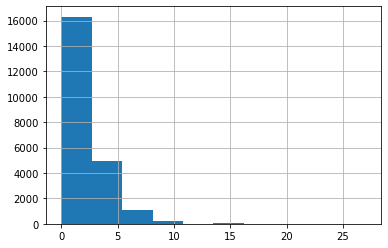

In [153]:
y.hist()

In [154]:
catcols = ['gender']
numcols = ['age','income']

parameters = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [50, 100],
}

pipe = Pipeline(steps = [
    ('preprocessing',column_transformer),
    ('model', RandomForestRegressor(random_state=0))
])

In [155]:
model = GridSearchCV(pipe, parameters, cv = 5, n_jobs = -1)
model.fit(X_train, y_train)
best_model = model.best_estimator_

In [156]:
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  ['gender']),
                                                 ('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'income'])])),
                ('model',
                 RandomForestRegressor(max_depth=5, min_samples_split=50,
                                       random_state=0))])

### 3.3.1. Evaluation

Mean Squared Error (MSE): 4.416965420487895
Root Mean Squared Error (RMSE): 2.101657779108648


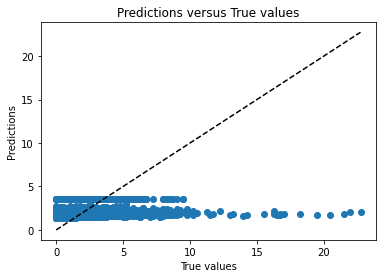

In [157]:
y_pred = best_model.predict(X_test)
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('Predictions versus True values')
plt.show()

<AxesSubplot:>

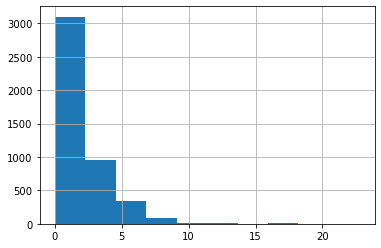

In [158]:
y_test.hist()

array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

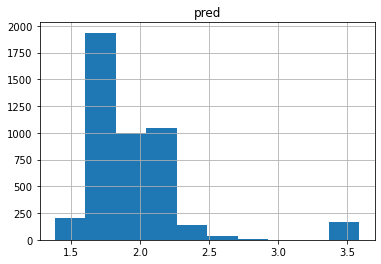

In [127]:
pd.DataFrame({'pred':y_pred}).hist()

In [128]:
joblib.dump(best_model, 'objects/ttc_offer.pkl', compress = True)

['objects/ttc_offer.pkl']

### 3.3.2. Refinement
What happend if we use the model of channel and difficulty (spend) like features in time to complete offer model?

In [162]:
best_channel_model = joblib.load('objects/best_channel.pkl')
spend_model = joblib.load('objects/spend.pkl')

In [167]:
df1[['pred_mobile','pred_web','pred_social']] = best_channel_model.predict(df1[['gender','age','income']])
df1['spend'] = spend_model.predict(df1[['gender','age','income']])

In [179]:
X = df1[['gender', 'age', 'income','pred_mobile','pred_web','pred_social','spend']]
y = df1['time_diff'] / 24

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [180]:
catcols = ['gender','pred_mobile','pred_web','pred_social']
numcols = ['age','income','spend']

cat_pipeline = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('encoding', OrdinalEncoder())
])

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

column_transformer = ColumnTransformer(transformers = [
    ('cat_pipeline', cat_pipeline, catcols),
    ('num_pipeline', num_pipeline, numcols)
    ],
    remainder = 'drop', # ignorar otras columnas
    n_jobs = -1)

parameters = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [50, 100],
}

pipe = Pipeline(steps = [
    ('preprocessing',column_transformer),
    ('model', RandomForestRegressor(random_state=0))
])

In [181]:
model = GridSearchCV(pipe, parameters, cv = 5, n_jobs = -1)
model.fit(X_train, y_train)
best_model = model.best_estimator_

In [182]:
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'pred_mobile',
                                                   'pred_web', 'pred_social']),
                                                 ('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'income',
                                                   'spend'])])),
                ('model',
                 RandomForestRegressor(max_depth=5, min_samples_split=50,
                                       random_state=0))])

Mean Squared Error (MSE): 4.418168395022212
Root Mean Squared Error (RMSE): 2.101943956203926


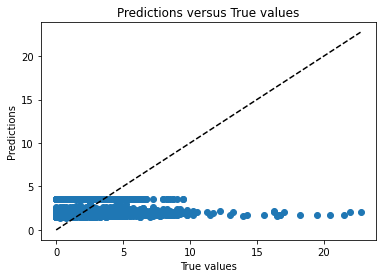

In [183]:
y_pred = best_model.predict(X_test)
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('Predictions versus True values')
plt.show()

In [ ]:
# the model does not improve significantly, so it is not worth including the predictions of the other models as features

# 4. Justification
As we have been able to observe in each of the models, creating a model for new clients with only 3 variables is quite complex.   
We use gridsearchcv as our tool to find the best hyperparameters in each model, and to ease the data processing task we use Pipeline and ColumnTransformer from sklearn.  
The approach I gave it is because I believe it is important to have a tool for new clients.  
Based on the history and the different profiles that we already know, we can estimate the offer that best suits each of the new clients, thus facilitating customization and opting for greater satisfaction.


# 5. Conclusion
The problem began by knowing how the demographic group can influence when offering an offer.  
On my side I raised the bet and asked myself what would happen if he is a new client? I found this question a bit more interesting.  
Being a new client, it is reasonable that the estimates are not the best, but they give us a north of what to offer to these clients.  
It is possible to improve this project in 2 ways:
- We have only used one type of algorithm for each model. Perhaps carrying out a benchmark with more models will give us a greater number of alternatives
- Try more hyperparameters. For hardware reasons, I only tried with a small set of hyperparameters.